# CNN

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

Hyper-parameters

In [21]:
batch_size = 32
learning_rate = 0.001

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Set train and test datasets

In [23]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../CIFAR10/data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../CIFAR10/data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders

In [24]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [25]:
classes = ('plane', 'car', 'brid', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Model

In [26]:
# Input size is 3 because we will send 3 types of color channels
input_size = 3
output_size = 6
kernel_size = 5

class ConvNet(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.configure_metrics()

        # Feature learning
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(output_size, 16, kernel_size)
        
        # Classification
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # def train_dataloader(self):
    #     return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # def val_dataloader(self):
    #     return torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    def configure_metrics(self):
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.valid_precision = torchmetrics.Precision(num_classes=10)
        self.valid_recall = torchmetrics.Recall(num_classes=10)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self(x)
        loss = nn.CrossEntropyLoss()(output, y)
        self.train_acc(output, y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, logger=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True, logger=True)
        
        return loss    

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self(x)
        loss = nn.CrossEntropyLoss()(output, y)
        
        self.valid_precision(output, y)
        self.valid_recall(output, y)
        self.valid_acc(output, y)
        self.log("precision", self.valid_precision, on_step=False, on_epoch=True, logger=True)
        self.log("recall", self.valid_recall, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', self.valid_acc, on_step=False, on_epoch=True, logger=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)

model = ConvNet(learning_rate)

In [27]:
from pytorch_lightning.callbacks import Callback

class MyCallback(Callback):
    def on_fit_start(self, trainer, pl_module):
        """Callback function that gets executed before the fit starts

        Parameters
        ----------
        trainer : pl.Trainer
            The trainer of the CNN module (pl_module)
        pl_module : pl.LightningModule
            The model we want to use to retrieve information
        """
        print("Starting to fit trainer!")
        
        self.writer = pl_module.logger.experiment
        pl_module.fc1.register_forward_hook(self.activation_hook)
        pl_module.fc2.register_forward_hook(self.activation_hook)
        pl_module.fc3.register_forward_hook(self.activation_hook)

    def activation_hook(self, inst, inp, out):
        """Run activation hook

        Parameters
        ----------
        inst : torch.nn.Module
            The layer we want to attach the hook to.
        inp : torch.Tensor
            The input to the `forward` method.
        out : torch.Tensor
            The output of the `forward` method.
        """
        # Create histogram of layer weights
        self.writer.add_histogram(repr(inst), out)

        img_grid = torchvision.utils.make_grid(inp[0])
        self.writer.add_image('Forward Input images', img_grid)

        img_grid = torchvision.utils.make_grid(out)
        self.writer.add_image('Forward Output images', img_grid)

## Find best learning rate

In [28]:
# trainer = pl.Trainer(auto_lr_find=True)
# lr_finder = trainer.tuner.lr_find(model)
# lr_finder.results
# fig = lr_finder.plot(suggest=True)
# fig.show()
# new_lr = lr_finder.suggestion()
# model.hparams.lr = new_lr
# print(new_lr)

## Train and validate

In [29]:
# trainer = pl.Trainer(max_epochs=2, callbacks=[MyCallback()])
# trainer.fit(model, train_dl, test_dl)

In [30]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


## Feature mapping
https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [31]:
print(model)

# Save the conv layers weights
model_weights = []
# Save the conv layers
conv_layers = []

# Get children of model
model_children = list(model.children())

ConvNet(
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
  (valid_precision): Precision()
  (valid_recall): Recall()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [32]:
counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [33]:
for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} =====> WEIGHT SHAPE: {weight.shape}")

CONV: Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)) =====> WEIGHT SHAPE: torch.Size([6, 3, 5, 5])
CONV: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) =====> WEIGHT SHAPE: torch.Size([16, 6, 5, 5])


## Visualizing Convolutional Layer Filters

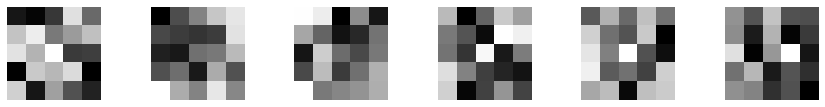

In [34]:
plt.figure(figsize=(15,12))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(6, 6, i+1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./outputs/filter.png')
plt.show()

## Reading the Image and Defining the Transforms

In [35]:
# Get images from dataloader
images, labels = iter(train_dl).next()

In [36]:
# Get single image from dataloader
image = images[5, :, :, :]
# Convert to numpy array
img = image.mean(dim=0)
# img = img / 2 + 0.5
img = img.numpy()
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


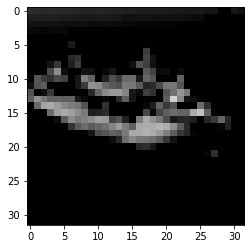

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [37]:
import cv2 as cv

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# img = transform(img)
print(type(image))
print(image.size())
# unsqueeze image to add a batch dimension
image = image.unsqueeze(0)
print(image.size())

## Passing the Input Image Through Each Convolutional Layer

In [39]:
# pass the image through the first layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the results for the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

outputs = results

## Visualizing the Feature Maps

torch.Size([6, 28, 28])
Saving layer 0 feature maps ...


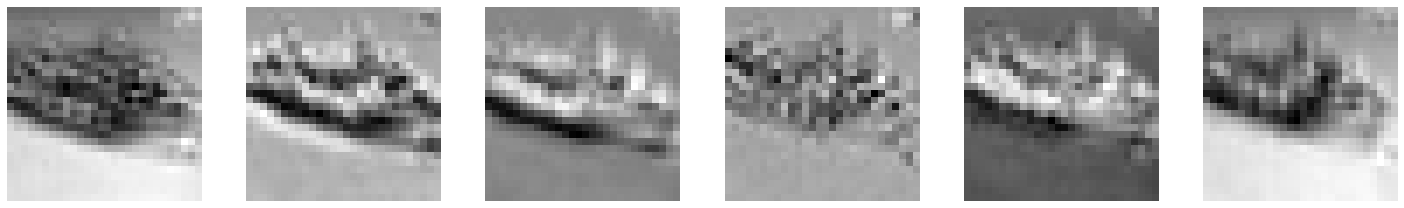

torch.Size([16, 24, 24])
Saving layer 1 feature maps ...


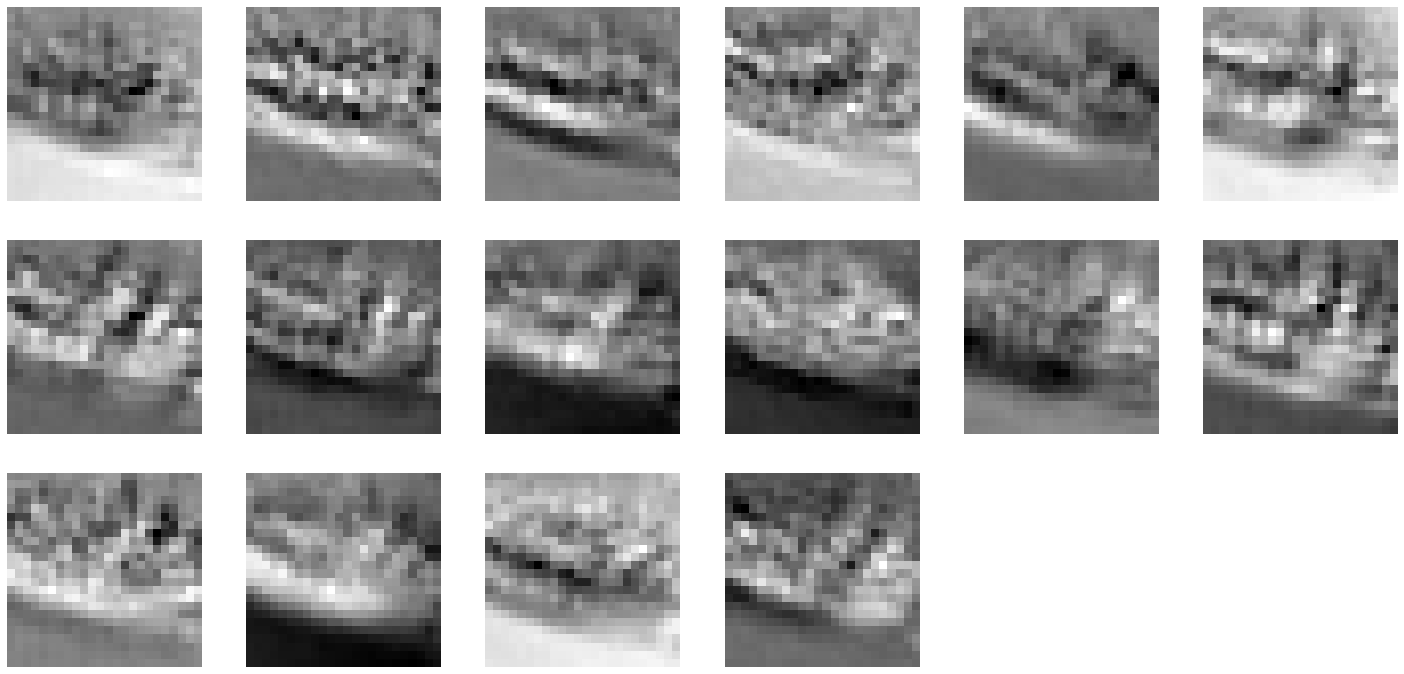

In [41]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(25, 25))
    # Take the first image of the batch [0, :, :, :]
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    
    amount = 64
    for i, filter in enumerate(layer_viz):
        if i == amount:
            break
        plt.subplot(6, 6, i+1)
        plt.imshow(filter, cmap='gray')
        plt.axis('off')
    print(f'Saving layer {num_layer} feature maps ...')
    plt.savefig(f'./outputs/layer_{num_layer}.png')
    plt.show()
    plt.close()

In [ ]:
# https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

# dataiter = iter(train_dl)
# images, labels = dataiter.next()

# image_arr = images.permute(1,2,0)

# Get predictions
# features = trainer.predict(model, train_dl)

# fig = plt.figure(figsize=(20,15))
# for i in range(1,features.shape[3]+1):

#     plt.subplot(8,8,i)
#     plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
# plt.show()